<a href="https://colab.research.google.com/github/mariacmorais/LLMCluestering/blob/main/Clustering4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Install dependencies if needed
# !pip install sentence-transformers umap-learn hdbscan pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings


In [39]:

# -----------------------------
# 1. Load Data (Multiline + Semicolon)
# -----------------------------
warnings.filterwarnings("ignore", category=SyntaxWarning)

file_path = 'complete_list.csv'

df = pd.read_csv(
    file_path,
    sep=';',
    quotechar='"',
    encoding='utf-8-sig',
    engine='python'
)

# Clean and filter columns
df = df.rename(columns=lambda x: x.strip().lower())
df = df.rename(columns={'gesture_definition': 'definition', 'gesture_name': 'name'})
df.dropna(subset=['definition'], inplace=True)
df['definition'] = df['definition'].str.strip()


In [40]:

# -----------------------------
# 2. Embed Using BioBERT
# -----------------------------
print("Loading model...")
model = SentenceTransformer('allenai/scibert_scivocab_uncased')

# Optional: Prompt Engineering
formatted_definitions = ["This surgical gesture is defined as: " + d for d in df['definition']]

print("Embedding definitions...")
embeddings = model.encode(formatted_definitions, show_progress_bar=True)



Loading model...


Embedding definitions...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [41]:
# -----------------------------
# 3. Dimensionality Reduction
# -----------------------------
scaled_embeddings = StandardScaler().fit_transform(embeddings)

print("Running UMAP...")
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(scaled_embeddings)


Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [42]:

# -----------------------------
# 4. Clustering
# -----------------------------
print("Clustering with HDBSCAN...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean')
cluster_labels = clusterer.fit_predict(umap_embeddings)

# Add to dataframe
df['Cluster'] = cluster_labels


Clustering with HDBSCAN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [43]:
# -----------------------------
# 5. Save and Inspect
# -----------------------------
df.to_csv("clustered_definitions.csv", index=False)
print("Clustered definitions saved to clustered_definitions.csv")



Clustered definitions saved to clustered_definitions.csv


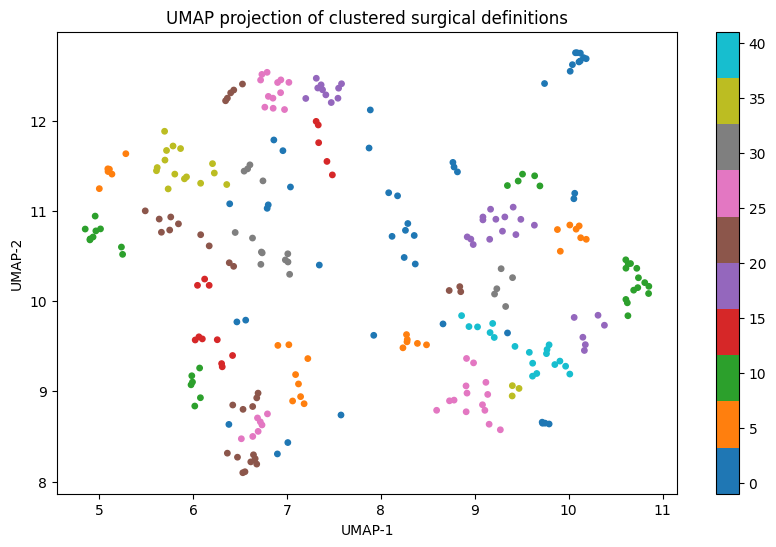

In [44]:
# -----------------------------
# 6. Visualization
# -----------------------------
plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='tab10', s=15)
plt.colorbar()
plt.title('UMAP projection of clustered surgical definitions')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()




In [45]:
# -----------------------------
# 7. Print Cluster Examples
# -----------------------------
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"\nNumber of clusters (excluding noise): {num_clusters}\n")

clusters = df.groupby("Cluster")

for cluster_id, group in clusters:
    if cluster_id == -1:
        continue  # Skip noise
    print(f"\n--- Cluster {cluster_id} ({len(group)} items) ---")
    for definition in group["definition"].head(3):  # show top 3 per cluster
        print(f"- {definition}")




Number of clusters (excluding noise): 42


--- Cluster 0 (10 items) ---
- Start: when the instrument tip touches the target with the intent to dissect it. End: when the instrument doesn’t touch the target anymore.
- The anatomical structure is cut by scissor. Started as soon as the cutting instrument began to close around tissue and ended with the complete closure of the cutting instrument[75] Start: when the instrument starts to fluidly close around a target. End: when the instrument is fully closed.
- 1. Navigate to the point of dissection. 2. Slowly penetrate the tissue. 3. Open the jaws to separate layers. 4. Pull out the instrument in an open position

--- Cluster 1 (3 items) ---
- Instruments are oriented to align with a target before grasping it. Common in needle pickup or tissue handling.
- The instrument or object is aligned to a target location and positioned precisely into place.
- A generic placement gesture where an item is positioned or set down in a designated area.

--

In [46]:
import plotly.express as px

# Create a DataFrame for plotting
plot_df = df.copy()
plot_df['UMAP-1'] = umap_embeddings[:, 0]
plot_df['UMAP-2'] = umap_embeddings[:, 1]

# You can show gesture name, definition, or both in the hover
plot_df['hover_text'] = plot_df['name'] + ": " + plot_df['definition'].str.slice(0, 150)

fig = px.scatter(
    plot_df,
    x="UMAP-1",
    y="UMAP-2",
    color=plot_df['Cluster'].astype(str),
    hover_name="name",
    hover_data={"definition": True, "Cluster": True},
    title="Interactive Clustering of Surgical Gestures"
)

fig.update_traces(marker=dict(size=6))
fig.show()